In [5]:
from pathlib import Path
from typing import Tuple
from collections import defaultdict

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np

# Load data
## Load files

In [6]:
metadata_path = Path('..') / 'data' / 'metadata_OS2006_ctdna.csv'
data_dir = Path('..') / 'data' / 'results'

In [7]:
metadata = pd.read_csv(metadata_path)

In [8]:
metadata.head()

,Unnamed: 0,CPA,Nb.Reads,sex,age,htum,relapse,etat2,id.x,time_point,time_OS,time_PFS
0,1,0.21416,34870298,Masculin,15.69,4.7,1,1,OS2006_22,DIAG,1918.0,496.0
1,2,0.16532,29805492,Masculin,15.69,4.7,1,1,OS2006_22,FIN_TTT,1918.0,496.0
2,3,0.15569,24460617,Feminin,33.76,4.0,0,0,OS2006_29,DIAG,3694.0,NaN
3,4,0.12670,30044657,Feminin,33.76,4.0,0,0,OS2006_29,FIN_TTT,3694.0,NaN
4,5,0.25768,38510628,Masculin,15.03,11.0,1,1,OS2006_97,DIAG,3017.0,637.0


In [9]:
def get_infos_from_filename(filename: str) -> Tuple[str, str]:
    filename = filename.split('.')[0]
    splitted_filename = filename.split('_')
    id_patient = f'{splitted_filename[0]}_{splitted_filename[1]}'
    time_point = f'{splitted_filename[2]}_{splitted_filename[3]}' if len(splitted_filename) == 4 else splitted_filename[2]
    return id_patient, time_point

In [10]:
def load_all_data_patient(data_dir: Path) -> defaultdict:
    data_patient = defaultdict(dict)

    for p in data_dir.iterdir():
        if not p.is_file():
            continue
        filename = str(p).split('/')[-1]
        id_patient, time_point = get_infos_from_filename(filename)
        data_patient[id_patient][time_point] = pd.read_csv(p, sep='\t')
    
    return data_patient

In [11]:
data_patient = load_all_data_patient(data_dir)
print(f'There are {len(data_patient)} patient')

There are 182 patient


## Organize data

In [12]:
patient_all_time_points = {patient_id: data for patient_id, data in data_patient.items() if len(data) == 3}
print(f'There are {len(patient_all_time_points)} patient with data for the 3 time points')

There are 115 patient with data for the 3 time points


In [13]:
patient_diag_time_point = {patient_id: {'DIAG': data['DIAG']} for patient_id, data in data_patient.items() if data.get('DIAG') is not None}
print(f'There are {len(patient_diag_time_point)} patient with data for DIAG time point')

There are 177 patient with data for DIAG time point


In [14]:
patient_chir_time_point = {patient_id: {'AVANT_CHIR': data['AVANT_CHIR']} for patient_id, data in data_patient.items() if data.get('AVANT_CHIR') is not None}
print(f'There are {len(patient_chir_time_point)} patient with data for AVANT_CHIR time point')

There are 143 patient with data for AVANT_CHIR time point


In [15]:
patient_end_time_point = {patient_id: {'FIN_TT': data['FIN_TT']} for patient_id, data in data_patient.items() if data.get('FIN_TT') is not None}
print(f'There are {len(patient_end_time_point)} patient with data for FIN_TT time point')

There are 143 patient with data for FIN_TT time point


## Check no error

In [16]:
nb_files = 0
for data in data_patient.values():
    nb_files += len(data.values())
nb_files

463

In [17]:
177 + 143 * 2

463

## Transform data
### Transpose data

In [18]:
def transpose_data_one_patient(data: pd.DataFrame) -> pd.DataFrame:
    one_data = data.copy()
    one_data = one_data[['id', 'ratio', 'zscore']].set_index('id').stack().reset_index()
    one_data.columns = ['id', 'score_label', 'value']
    one_data['col_name'] = one_data['id'] + '_' + one_data['score_label']
    return one_data.set_index('col_name')['value'].to_frame().T

In [19]:
def format_all_data_as_df(patient_data: defaultdict) -> pd.DataFrame:
    transpose_data = []
    ids_patient = []
    
    for patient_id, data in patient_data.items():
        for time_point, data in data.items():
            transpose_data.append(transpose_data_one_patient(data))
            ids_patient.append((patient_id, time_point))
        
    transpose_data_df = pd.concat(transpose_data, axis=0).reset_index(drop=True)
    ids_patient_df = pd.DataFrame(ids_patient, columns=['patient_id', 'time_point'])
    
    return pd.concat([ids_patient_df, transpose_data_df], axis=1)

In [20]:
patient_all_time_points_df = format_all_data_as_df(patient_all_time_points)

In [21]:
patient_diag_time_point_df = format_all_data_as_df(patient_diag_time_point)

In [22]:
patient_chir_time_point_df = format_all_data_as_df(patient_chir_time_point)

In [23]:
patient_end_time_point_df = format_all_data_as_df(patient_end_time_point)

## Clean metadata

In [24]:
metadata_df = metadata.copy()
del metadata_df['Unnamed: 0']

In [25]:
metadata_df = metadata_df.sort_values('CPA', ascending=False).drop_duplicates(['id.x', 'time_point'], keep='first')

In [26]:
metadata_df.rename(columns={'id.x': 'patient_id'}, inplace=True)
metadata_df['time_point'] = metadata_df['time_point'].str.replace('FIN_TTT', 'FIN_TT')

## Merge metadata and data

In [27]:
data_all_time_points = pd.merge(metadata_df, patient_all_time_points_df, on=['patient_id', 'time_point'], how='right')
columns_to_keep = ['patient_id', 'time_point'] + [col for col in data_all_time_points.columns if col.endswith('_ratio') or col.endswith('_zscore')]
data_all_time_points = data_all_time_points[columns_to_keep].set_index(['time_point', 'patient_id']).unstack('time_point')
data_all_time_points.columns = ['_'.join(col).strip() for col in data_all_time_points.columns.values]
data_all_time_points.reset_index(inplace=True)
data_all_time_points = pd.merge(metadata_df[['patient_id', 'sex', 'age', 'htum', 'relapse', 'etat2']], data_all_time_points, on='patient_id', how='right').drop_duplicates('patient_id').reset_index(drop=True)

In [28]:
data_all_time_points.head()

,patient_id,sex,age,htum,relapse,etat2,1:1000001-2000000_ratio_AVANT_CHIR,1:1000001-2000000_ratio_DIAG,1:1000001-2000000_ratio_FIN_TT,1:1000001-2000000_zscore_AVANT_CHIR,...,Y:56000001-57000000_ratio_FIN_TT,Y:56000001-57000000_zscore_AVANT_CHIR,Y:56000001-57000000_zscore_DIAG,Y:56000001-57000000_zscore_FIN_TT,8:76000001-77000000_ratio_AVANT_CHIR,8:76000001-77000000_ratio_DIAG,8:76000001-77000000_ratio_FIN_TT,8:76000001-77000000_zscore_AVANT_CHIR,8:76000001-77000000_zscore_DIAG,8:76000001-77000000_zscore_FIN_TT
0,OS2006_1,Feminin,17.58,10.6,0.0,0.0,0.018393,0.016137,0.058340,0.717335,...,NaN,NaN,NaN,NaN,NaN,NaN,0.042338,NaN,NaN,1.339005
1,OS2006_10,Masculin,14.51,11.1,0.0,1.0,0.061683,-0.073297,0.049724,2.439719,...,-0.067204,-0.229573,-1.442374,-1.568502,NaN,NaN,NaN,NaN,NaN,NaN
2,OS2006_11,Masculin,18.83,7.0,0.0,0.0,0.001686,0.044181,0.007257,0.057659,...,0.205231,4.687495,4.854536,7.090777,NaN,0.044237,NaN,NaN,1.504716,NaN
3,OS2006_12,Feminin,11.69,12.4,0.0,0.0,-0.109241,-0.112703,-0.049262,-1.915631,...,NaN,NaN,NaN,NaN,NaN,-0.091530,NaN,NaN,-1.151688,NaN
4,OS2006_149,Feminin,15.91,8.0,1.0,0.0,0.047129,0.094966,0.124527,1.828972,...,NaN,NaN,NaN,NaN,NaN,NaN,0.016699,NaN,NaN,0.504069


In [29]:
data_diag = pd.merge(metadata_df, patient_diag_time_point_df, on=['patient_id', 'time_point'], how='right')
data_chir = pd.merge(metadata_df, patient_chir_time_point_df, on=['patient_id', 'time_point'], how='right')
data_end = pd.merge(metadata_df, patient_end_time_point_df, on=['patient_id', 'time_point'], how='right')

In [30]:
data_diag.head()

,CPA,Nb.Reads,sex,age,htum,relapse,etat2,patient_id,time_point,time_OS,...,Y:20000001-21000000_ratio,Y:20000001-21000000_zscore,Y:21000001-22000000_ratio,Y:21000001-22000000_zscore,Y:56000001-57000000_ratio,Y:56000001-57000000_zscore,2:225000001-226000000_ratio,2:225000001-226000000_zscore,8:76000001-77000000_ratio,8:76000001-77000000_zscore
0,0.17828,7557775.0,Feminin,46.16,4.1,1.0,1.0,OS2006_273,DIAG,1966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.20886,2062129.0,Masculin,15.93,13.3,0.0,0.0,OS2006_20,DIAG,2017.0,...,-0.075287,-0.983087,-0.061387,-0.743372,0.030197,0.363847,NaN,NaN,NaN,NaN
2,0.90081,39551556.0,Masculin,13.64,11.0,1.0,1.0,OS2006_37,DIAG,743.0,...,0.068260,0.667947,0.142330,1.608445,-0.451219,-5.174899,NaN,NaN,NaN,NaN
3,0.78868,51066283.0,Masculin,15.75,12.0,1.0,0.0,OS2006_320,DIAG,2307.0,...,-0.368986,-3.677375,-0.312518,-3.143064,-0.033962,-0.449842,NaN,NaN,NaN,NaN
4,0.83122,1664501.0,Masculin,8.40,6.8,1.0,1.0,OS2006_504,DIAG,423.0,...,-0.216662,-2.878748,-0.087349,-1.327402,-0.082043,-1.076253,-0.154327,-2.448759,NaN,NaN


In [31]:
join_columns = ['patient_id', 'sex', 'age', 'htum', 'relapse']
columns_to_keep = join_columns + ['CPA']

metadata_diag = metadata_df.loc[metadata_df['time_point'] == 'DIAG', columns_to_keep]
metadata_diag.rename(columns={'CPA': 'CPA_DIAG'}, inplace=True)

metadata_chir = metadata_df.loc[metadata_df['time_point'] == 'AVANT_CHIR', columns_to_keep]
metadata_chir.rename(columns={'CPA': 'CPA_AVANT_CHIR'}, inplace=True)

metadata_end = metadata_df.loc[metadata_df['time_point'] == 'FIN_TT', columns_to_keep]
metadata_end.rename(columns={'CPA': 'CPA_FIN_TT'}, inplace=True)

metadata_patients_all_time_points = pd.merge(metadata_diag, metadata_chir, how='inner', on=join_columns)
metadata_patients_all_time_points = pd.merge(metadata_patients_all_time_points, metadata_end, how='inner', on=join_columns)

In [32]:
metadata_patients_all_time_points.head()

,patient_id,sex,age,htum,relapse,CPA_DIAG,CPA_AVANT_CHIR,CPA_FIN_TT
0,OS2006_424,Feminin,12.91,9.3,1,1.73994,0.14075,0.16581
1,OS2006_489,Feminin,10.17,13.0,1,1.38208,0.22717,0.21355
2,OS2006_543,Feminin,15.62,15.0,1,1.37484,0.16444,0.17992
3,OS2006_252,Feminin,12.10,6.7,0,1.31617,0.25735,0.14705
4,OS2006_430,Feminin,8.25,7.0,0,1.25124,0.25564,0.16828


# Data Analysis
## Metadata
### General infos

In [33]:
metadata_df.describe()

,CPA,Nb.Reads,age,htum,relapse,etat2,time_OS,time_PFS
count,463.000000,4.630000e+02,463.000000,446.000000,463.000000,463.000000,451.000000,186.000000
mean,0.302289,1.908883e+07,15.149201,10.908969,0.399568,0.263499,1492.558758,594.236559
std,0.286295,1.458161e+07,5.881494,4.838201,0.490339,0.441007,754.932820,409.957226
min,0.074450,8.727000e+03,4.710000,1.300000,0.000000,0.000000,181.000000,46.000000
25%,0.156005,7.760510e+06,11.710000,7.525000,0.000000,0.000000,882.000000,357.500000
50%,0.196720,1.454245e+07,14.370000,10.000000,0.000000,0.000000,1352.000000,525.000000
75%,0.316125,2.877754e+07,16.915000,13.075000,1.000000,1.000000,2055.500000,669.000000
max,2.627000,1.195946e+08,50.410000,32.000000,1.000000,1.000000,3694.000000,2786.000000


In [34]:
metadata_df['time_point'].value_counts()

DIAG          174
AVANT_CHIR    142
FIN_TT        141
1_AN            6
Name: time_point, dtype: int64

In [35]:
metadata_df['sex'].value_counts()

Masculin    246
Feminin     217
Name: sex, dtype: int64

### CPA VS Relapse

In [36]:
def hist_by_time_point(metadata : pd.DataFrame, column_name: str, bins: np.array) -> None:
    data_diag = metadata.loc[metadata['time_point'] == 'DIAG', column_name]
    data_chir = metadata_df.loc[metadata['time_point'] == 'AVANT_CHIR', column_name]
    data_end = metadata.loc[metadata['time_point'] == 'FIN_TT', column_name]

    plt.figure(figsize=(10, 5))
    plt.hist(data_diag, bins=bins, alpha=0.5, label='DIAG', density=True)
    plt.hist(data_chir, bins=bins, alpha=0.5, label='AVANT_CHIR', density=True)
    plt.hist(data_end, bins=bins, alpha=0.5, label='FIN_TT', density=True)
    plt.title(f'histogram of {column_name} per timepoint')
    plt.legend(loc='upper right')
    plt.show()


def hist_one_time_point(metadata : pd.DataFrame, column_name: str, bins: np.array, time_point:str) -> None:
    data_diag_relapse = metadata.loc[(metadata['time_point'] == time_point) & (metadata['relapse'] == 1), column_name]
    data_diag_no_relapse = metadata.loc[(metadata['time_point'] == time_point) & (metadata['relapse'] == 0), column_name]

    plt.figure(figsize=(10, 5))
    plt.hist(data_diag_relapse, bins=bins, alpha=0.5, label='RELAPSE', color='r', density=True)
    plt.hist(data_diag_no_relapse, bins=bins, alpha=0.5, label='NO RELAPSE', color='g', density=True)
    plt.title(f'histogram for {column_name} of  at {time_point} relapse vs no relapse')
    plt.legend(loc='upper right')
    plt.show()

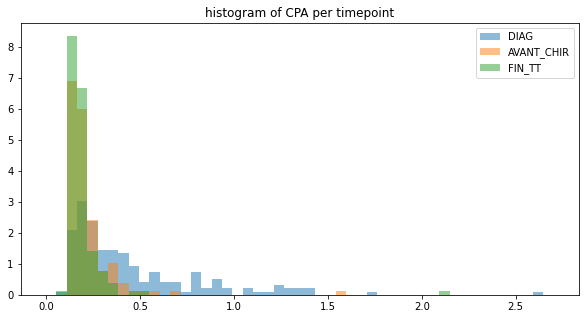

In [37]:
bins = np.linspace(0, 2.7, 50)
hist_by_time_point(metadata_df, 'CPA', bins)

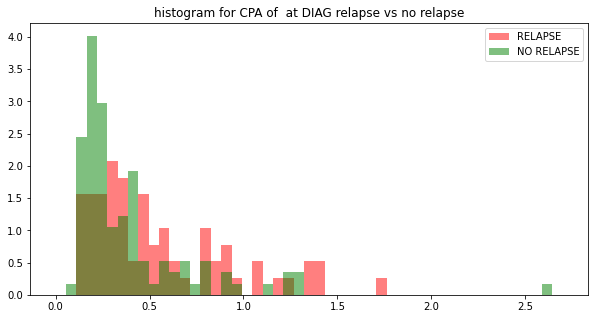

In [43]:
bins = np.linspace(0, 2.7, 50)
hist_one_time_point(metadata_df, 'CPA', bins, 'DIAG')

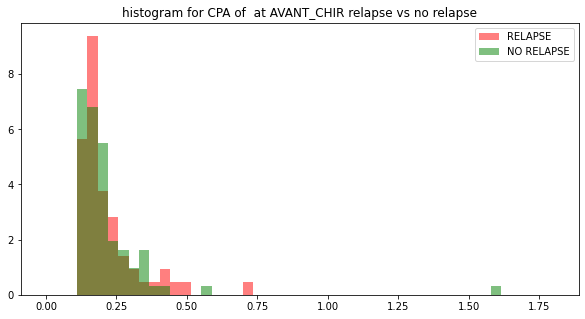

In [44]:
bins = np.linspace(0, 1.8, 50)
hist_one_time_point(metadata_df, 'CPA', bins, 'AVANT_CHIR')

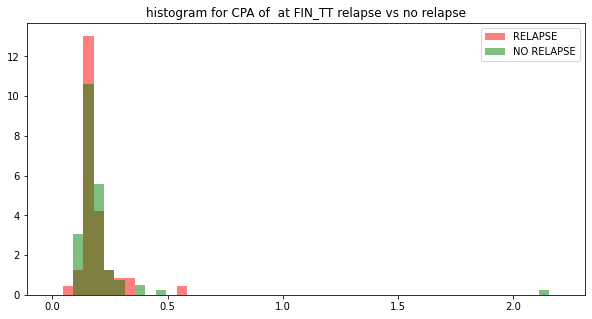

In [45]:
bins = np.linspace(0, 2.2, 50)
hist_one_time_point(metadata_df, 'CPA', bins, 'FIN_TT')

### Htum VS Relapse

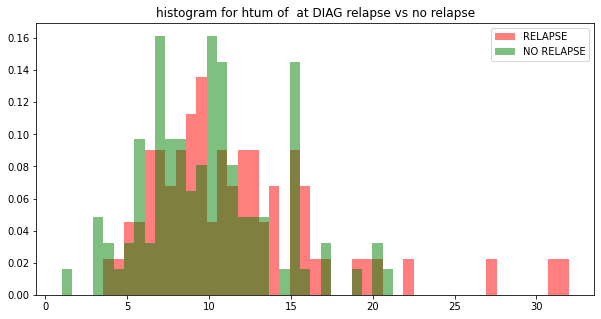

In [46]:
bins = np.linspace(1, 32, 50)
hist_one_time_point(metadata_df, 'htum', bins, 'DIAG')

### Age vs relapse

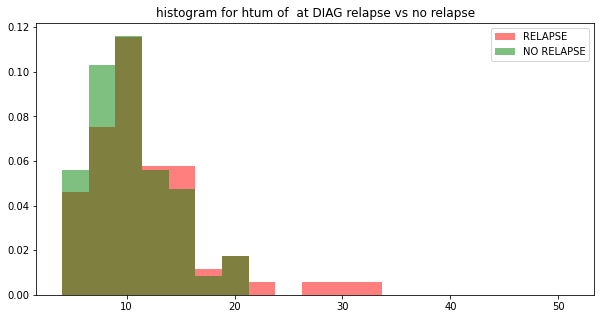

In [47]:
bins = np.linspace(4, 51, 20)
hist_one_time_point(metadata_df, 'htum', bins, 'DIAG')

## Outliers

In [91]:
metadata_df.loc[metadata_df['CPA'] > 2, 'patient_id']

132     OS2006_34
518    OS2006_548
Name: patient_id, dtype: object

In [92]:
metadata_df.loc[(metadata_df['CPA'] > 1.5) & (metadata_df['time_point'] == 'AVANT_CHIR'), 'patient_id']

236    OS2006_20
Name: patient_id, dtype: object

In [33]:
outliers_ids = ['OS2006_34', 'OS2006_548', 'OS2006_20']

# ML models on metadata
## Compute features

In [38]:
metadata_patients_all_time_points.head()

,patient_id,sex,age,htum,relapse,CPA_DIAG,CPA_AVANT_CHIR,CPA_FIN_TT
0,OS2006_424,Feminin,12.91,9.3,1,1.73994,0.14075,0.16581
1,OS2006_489,Feminin,10.17,13.0,1,1.38208,0.22717,0.21355
2,OS2006_543,Feminin,15.62,15.0,1,1.37484,0.16444,0.17992
3,OS2006_252,Feminin,12.10,6.7,0,1.31617,0.25735,0.14705
4,OS2006_430,Feminin,8.25,7.0,0,1.25124,0.25564,0.16828


In [35]:
features = metadata_patients_all_time_points.copy()
print(f'Initial features shape : {features.shape}')

features['sex'] = features.apply(lambda x: 0 if x['sex'] == 'Feminin' else 1, axis=1)
features = features[~features['patient_id'].isin(outliers_ids)]
features.dropna(inplace=True, axis=0)
features.reset_index(drop=True, inplace=True)

print(f'Features shape after some cleaning: {features.shape}')

label = 'relapse'
labels = features[label]
del features[label]
del features['patient_id']

Initial features shape : (113, 8)
Features shape after some cleaning: (106, 8)


In [36]:
features_to_scale = ['age', 'htum', 'CPA_DIAG', 'CPA_AVANT_CHIR', 'CPA_FIN_TT']

skf = StratifiedKFold(n_splits=5)
model = RandomForestClassifier()
train_results = list()
test_results = list()

for train_index, test_index in skf.split(features, labels):
    features_tmp_train = features.loc[train_index, :]
    features_tmp_test = features.loc[test_index, :]

    ss = StandardScaler()
    features_tmp_train[features_to_scale] = ss.fit_transform(features_tmp_train[features_to_scale])
    features_tmp_test[features_to_scale] = ss.transform(features_tmp_test[features_to_scale])
    
    model.fit(features_tmp_train, labels[train_index])
    
    y_train_pred = model.predict(features_tmp_train)
    train_score = round(100 * accuracy_score(labels[train_index], y_train_pred), 1)
    train_results.append(train_score)
    
    y_test_pred = model.predict(features_tmp_test)
    test_score = round(100 * accuracy_score(labels[test_index], y_test_pred), 1)
    test_results.append(test_score)

In [37]:
print(f'Accuracy on train : {train_results}')
print(f'Accuracy on test : {test_results}')

Accuracy on train : [100.0, 100.0, 100.0, 100.0, 100.0]
Accuracy on test : [40.9, 33.3, 23.8, 52.4, 61.9]


In [38]:
test_results

[40.9, 33.3, 23.8, 52.4, 61.9]

# Plot PCA of raw data

In [39]:
def remove_x_and_y_chrom(features: pd.DataFrame) -> pd.DataFrame:
    return features[[x for x in features.columns if not (x.startswith('X:') or x.startswith('Y:'))]]

def remove_row(data_with_label: pd.DataFrame, idx_rows: list) -> pd.DataFrame:
    filtered_data_with_label = data_with_label.copy()
    filtered_data_with_label = filtered_data_with_label[~filtered_data_with_label.index.isin(idx_rows)].reset_index(drop=True)
        
    return filtered_data_with_label

In [40]:
def compute_features(data: pd.DataFrame) -> pd.DataFrame:
    features = data[[x for x in data.columns if '_ratio' in x]]
    features = remove_x_and_y_chrom(features)
    features.fillna(0, inplace=True)
    return features

In [41]:
def plot_data(data_with_label: pd.DataFrame, data_2_dims: np.array, time_point: str) -> None:
    plt.figure(figsize=(10,10))
    targets = ['no relapse', 'relapse']
    colors = ['g', 'r']
    plt.title(f'Plot of each patient : {time_point}', fontsize=20)

    for target, color in zip(targets, colors):
        idx_target = targets.index(target)
        idx_to_keep = data_with_label[data_with_label['relapse'] == idx_target].index.tolist()
        plt.scatter(data_2_dims[idx_to_keep, 0],
                    data_2_dims[idx_to_keep, 1], 
                    c=color, s=50)

    plt.legend(targets,prop={'size': 15})
    plt.show()

In [42]:
def plot_pca(data_with_label: pd.DataFrame, time_point: str, idx_rows_to_remove: list = None) -> None:
    if idx_rows_to_remove is not None:
        data_with_label = remove_row(data_with_label, idx_rows_to_remove)
    features = compute_features(data_with_label)
    pca_2 = PCA(n_components=2)
    features_2 = pca_2.fit_transform(features)
    plot_data(data_with_label, features_2, time_point)

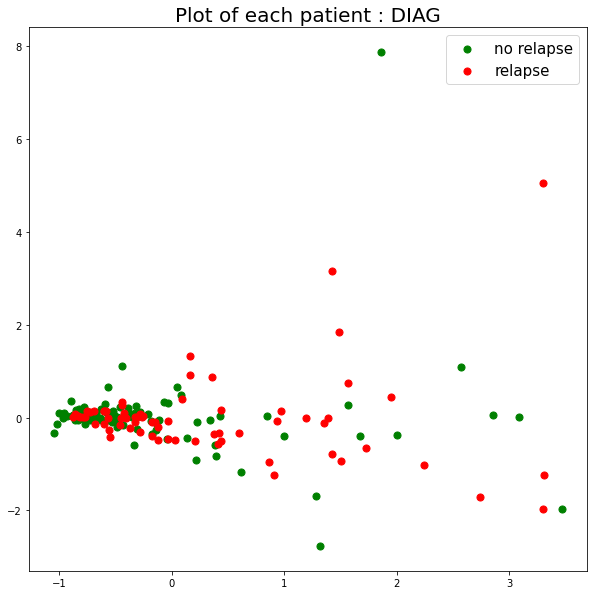

In [30]:
plot_pca(data_diag, 'DIAG')

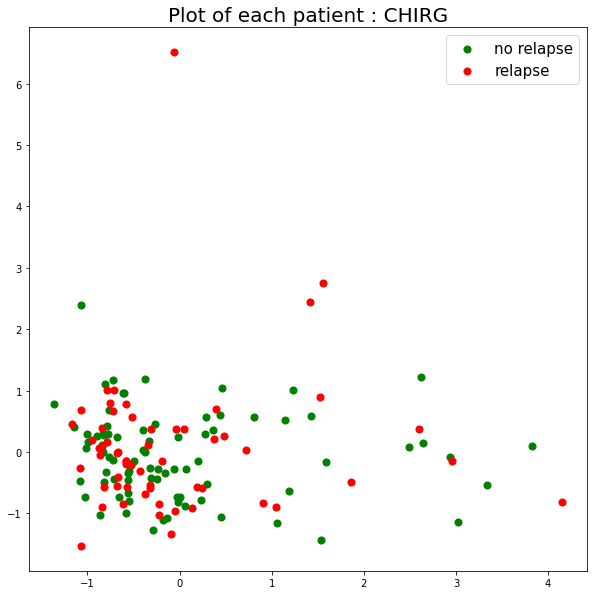

In [31]:
plot_pca(data_chir, 'CHIRG', idx_rows_to_remove=[1])

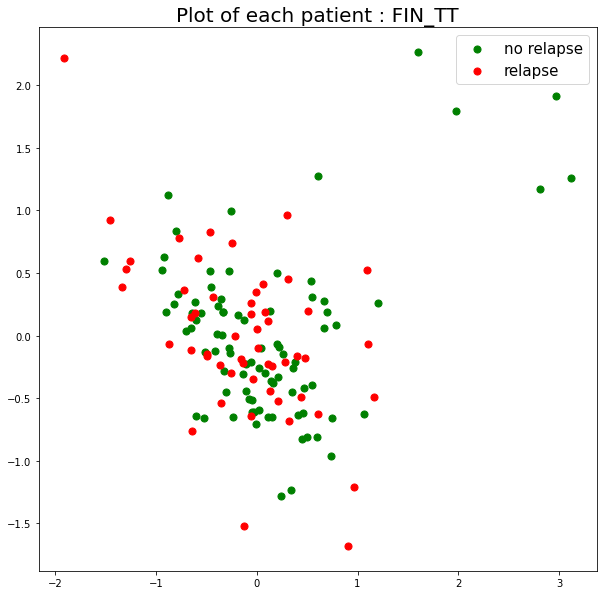

In [32]:
plot_pca(data_end, 'FIN_TT', idx_rows_to_remove=[56])

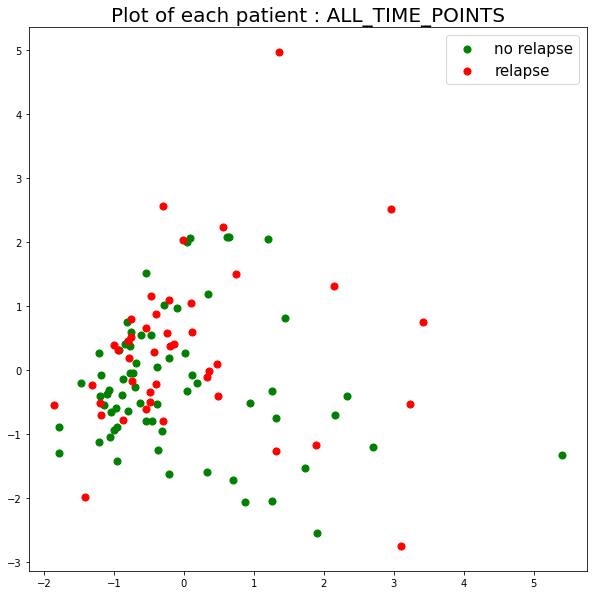

In [33]:
plot_pca(data_all_time_points, 'ALL_TIME_POINTS', idx_rows_to_remove=[11, 83])

# Plot TSNE

In [34]:
def plot_tsne(data_with_label: pd.DataFrame, time_point: str, idx_rows_to_remove: list = None) -> None:
    if idx_rows_to_remove is not None:
        data_with_label = remove_row(data_with_label, idx_rows_to_remove)
    features = compute_features(data_with_label)
    tsne_2 = TSNE(n_components=2)
    features_2 = tsne_2.fit_transform(features)

    plot_data(data_with_label, features_2, time_point)

/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


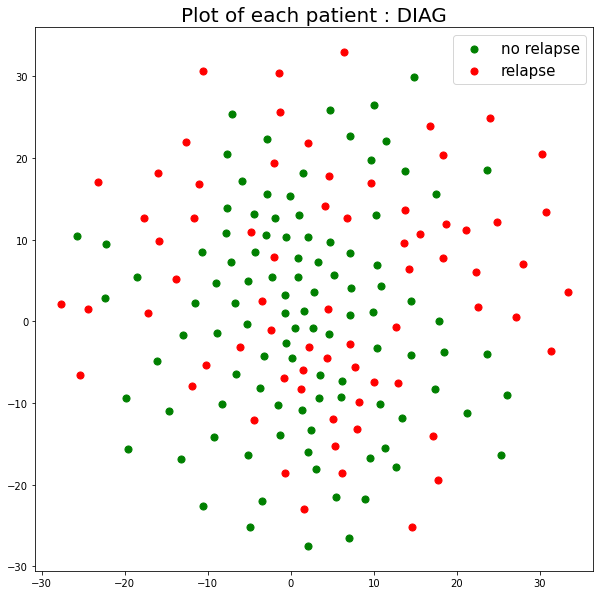

In [35]:
plot_tsne(data_diag, 'DIAG')

/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


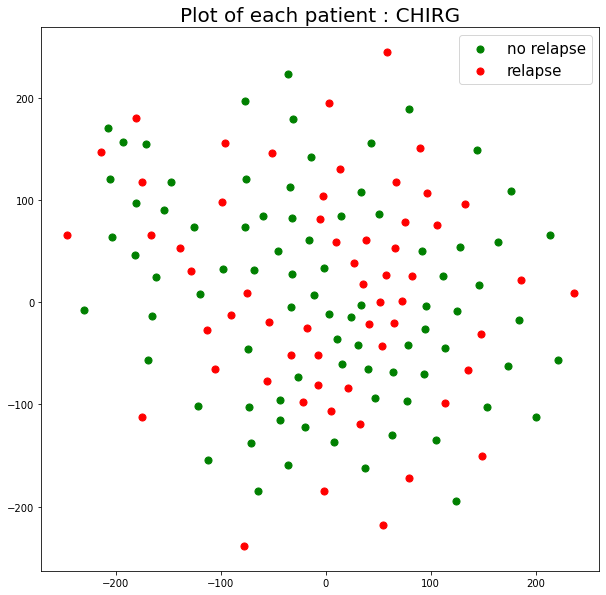

In [36]:
plot_tsne(data_chir, 'CHIRG', idx_rows_to_remove=[1])

/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


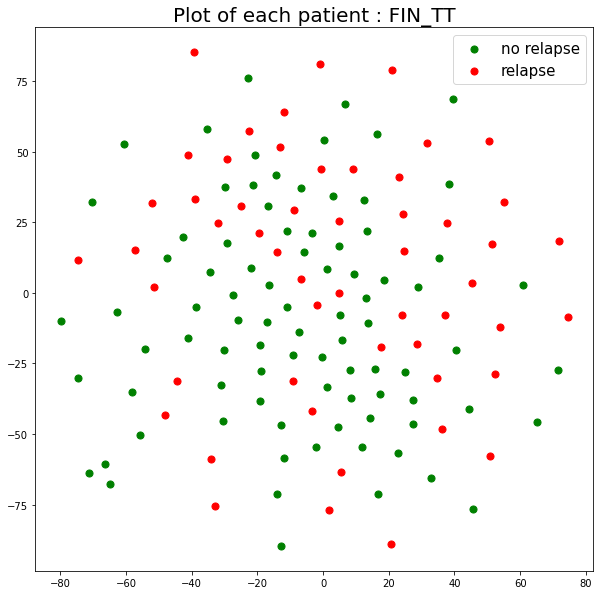

In [37]:
plot_tsne(data_end, 'FIN_TT', idx_rows_to_remove=[56])

/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lhericourt/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


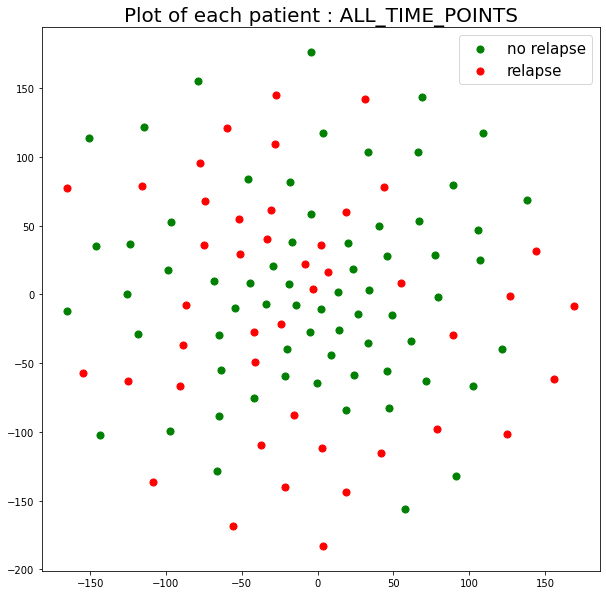

In [38]:
plot_tsne(data_all_time_points, 'ALL_TIME_POINTS', idx_rows_to_remove=[11, 83])

# Reduce nb features
## Min, max, mean, var

In [43]:
def aggregate_data_one_chromosome(chrom_nb: str, data: pd.Series, function: callable, score=str) -> float:
    columns_chrom = [col_name for col_name in data.index if col_name.startswith(chrom_nb + ':') and col_name.endswith(score)]
    return function(data[columns_chrom])

In [44]:
data_diag.head()

,CPA,Nb.Reads,sex,age,htum,relapse,etat2,patient_id,time_point,time_OS,...,Y:20000001-21000000_ratio,Y:20000001-21000000_zscore,Y:21000001-22000000_ratio,Y:21000001-22000000_zscore,Y:56000001-57000000_ratio,Y:56000001-57000000_zscore,2:225000001-226000000_ratio,2:225000001-226000000_zscore,8:76000001-77000000_ratio,8:76000001-77000000_zscore
0,0.17828,7557775.0,Feminin,46.16,4.1,1.0,1.0,OS2006_273,DIAG,1966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.20886,2062129.0,Masculin,15.93,13.3,0.0,0.0,OS2006_20,DIAG,2017.0,...,-0.075287,-0.983087,-0.061387,-0.743372,0.030197,0.363847,NaN,NaN,NaN,NaN
2,0.90081,39551556.0,Masculin,13.64,11.0,1.0,1.0,OS2006_37,DIAG,743.0,...,0.068260,0.667947,0.142330,1.608445,-0.451219,-5.174899,NaN,NaN,NaN,NaN
3,0.78868,51066283.0,Masculin,15.75,12.0,1.0,0.0,OS2006_320,DIAG,2307.0,...,-0.368986,-3.677375,-0.312518,-3.143064,-0.033962,-0.449842,NaN,NaN,NaN,NaN
4,0.83122,1664501.0,Masculin,8.40,6.8,1.0,1.0,OS2006_504,DIAG,423.0,...,-0.216662,-2.878748,-0.087349,-1.327402,-0.082043,-1.076253,-0.154327,-2.448759,NaN,NaN


In [45]:
def compute_min_max_mean_var_by_chrom(data: pd.DataFrame, score:str) -> pd.DataFrame:
    data_update = data.copy()
    for chrom_nb in range(1, 22):
        for func in [min, max, np.mean, np.var]:
            data_update[f'{func.__name__}_{chrom_nb}'] =  data_update.apply(lambda x: aggregate_data_one_chromosome(str(chrom_nb), x, func, score), axis=1)
    columns_to_keep = [col_name for col_name in data_update.columns if col_name.startswith(('min', 'max', 'mean', 'var'))]
    return data_update[columns_to_keep]

In [46]:
def clean_features_and_labels(features: pd.DataFrame, labels: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    idx_to_remove = labels[labels.isnull()].index.tolist()
    
    features = features.loc[~features.index.isin(idx_to_remove), :].reset_index(drop=True)
    features.fillna(0, inplace=True)
    
    labels = labels[~labels.isnull()].reset_index(drop=True)
    
    return features, labels

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#import lightgbm as lgb


def compute_features_and_labels(data: pd.DataFrame, score: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    features = compute_min_max_mean_var_by_chrom(data, score)
    labels = data['relapse']
    
    features, labels = clean_features_and_labels(features, labels)
    return features, labels


def train_model(model, features: pd.DataFrame, labels: pd.DataFrame, test_size: float, seed: int) -> None:
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=seed)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    print(f'Accuracy on train : {round(100 * accuracy_score(y_pred, y_train))} %')
    
    y_pred = model.predict(X_test)
    print(f'Accuracy on test : {round(100 * accuracy_score(y_pred, y_test))} %')

### Test on DIAG data - ratio

In [50]:
features

,min_1,max_1,mean_1,var_1,min_2,max_2,mean_2,var_2,min_3,max_3,...,mean_19,var_19,min_20,max_20,mean_20,var_20,min_21,max_21,mean_21,var_21
0,-0.117921,0.084780,-0.009894,0.001551,-0.130508,0.127528,0.000933,0.001781,-0.095819,0.104289,...,-0.023519,0.001839,-0.189380,0.115768,-0.006145,0.002725,-0.144424,0.101028,-0.015143,0.003201
1,-0.281187,0.174947,-0.011333,0.004847,-0.253981,0.159148,-0.011177,0.005401,-0.255906,0.174993,...,-0.015458,0.007934,-0.237579,0.293557,0.006927,0.006929,-0.143285,0.136547,-0.019309,0.005493
2,-0.047312,0.216161,0.083128,0.001856,-0.144786,0.249242,0.000731,0.010795,-0.088932,0.156113,...,-0.012921,0.006243,-0.153251,0.393945,0.063907,0.013655,-0.075876,0.058112,0.005002,0.000779
3,-0.139317,0.190704,0.038173,0.006648,-0.125134,0.762426,0.037155,0.018587,-0.151417,0.095858,...,0.068963,0.021411,-0.069265,0.103038,0.046956,0.000874,0.002472,0.367760,0.323791,0.003783
4,-0.148064,0.277938,-0.016679,0.003605,-0.205848,0.134170,0.012167,0.004416,-0.361370,0.445130,...,0.018863,0.006996,-0.056379,0.109810,0.047635,0.001111,-0.127639,0.010617,-0.037031,0.001226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,-0.094985,0.091416,0.009532,0.001286,-0.093841,0.131521,0.011789,0.001205,-0.124256,0.068455,...,-0.013238,0.001413,-0.116629,0.075787,0.007648,0.001670,-0.096722,0.055698,-0.011537,0.001351
169,-0.169401,0.179463,0.000884,0.002863,-0.110270,0.123043,-0.015379,0.001373,-0.147304,0.099462,...,-0.009791,0.002943,-0.094654,0.086498,-0.030760,0.000931,-0.131625,0.266878,0.028225,0.011970
170,-0.009496,0.250815,0.058564,0.002280,-0.066817,0.127242,0.017145,0.000838,-0.150356,0.776470,...,-0.026340,0.005311,-0.079454,0.129328,0.023875,0.003496,-0.101846,0.065133,0.004015,0.001126
171,-0.245828,0.238476,0.033659,0.004485,-0.279572,0.338143,0.005660,0.023710,-0.278580,0.330573,...,-0.001642,0.001358,-0.315841,0.203213,-0.111499,0.009849,-0.151193,0.089642,0.003936,0.002118


In [49]:
TEST_SIZE = 0.3
SEED = 43

features, labels = compute_features_and_labels(data_diag, score='ratio')

In [332]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 67 %
Accuracy on test : 67 %


In [326]:
rf = RandomForestClassifier(n_estimators=10, random_state=SEED)
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 99 %
Accuracy on test : 63 %


In [71]:
cols_starts_to_keep = tuple([f'{i}:' for i in range(1, 22)])
cols_to_keep = [col for col in data_diag.columns if col.startswith(cols_starts_to_keep)]

features = data_end[cols_to_keep]
labels = data_end['relapse']
#clean_features_and_labels()

In [72]:
features, labels = clean_features_and_labels(features, labels)

In [73]:
features.columns = [str(i) for i in range(features.shape[1])]

In [74]:
 X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=TEST_SIZE, stratify=labels, random_state=SEED)

fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'multi_error', 
            "eval_set" : [(X_test, y_test)],
            'eval_names': ['valid'],
            'verbose': 1000,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(num_leaves= 255, max_depth=-1, #15
                         seed=42, 
                         objective="binary",
                         verbose=1,
                         num_threads=-1, 
                         n_estimators=100000,
                         colsample_bytree=0.7,
                         subsample=0.8,
                         learning_rate=0.01)        
clf.fit(X_train, y_train, **fit_params)

/home/lhericourt/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/lhericourt/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] Number of positive: 37, number of negative: 61
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168555
[LightGBM] [Info] Number of data points in the train set: 98, number of used features: 4922
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377551 -> initscore=-0.499956
[LightGBM] [Info] Start training from score -0.499956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, n_estimators=100000,
               num_leaves=255, num_threads=-1, objective='binary', seed=42,
               subsample=0.8, verbose=1)

In [75]:

y_pred = clf.predict(X_train)
print(f'Accuracy on train : {round(100 * accuracy_score(y_pred, y_train))} %')

y_pred = clf.predict(X_test)
print(f'Accuracy on test : {round(100 * accuracy_score(y_pred, y_test))} %')

Accuracy on train : 82 %
Accuracy on test : 67 %


### Test on DIAG data - z-score

In [334]:
features, labels = compute_features_and_labels(data_diag, score='zscore')

In [338]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 95 %
Accuracy on test : 73 %


In [336]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 99 %
Accuracy on test : 67 %


### Test on CHIR data - ratio

In [50]:
features, labels = compute_features_and_labels(data_chir, score='ratio')

In [340]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 60 %
Accuracy on test : 58 %


In [341]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 97 %
Accuracy on test : 49 %


### Test on CHIR data - zscore

In [342]:
features, labels = compute_features_and_labels(data_chir, score='zscore')

In [343]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 91 %
Accuracy on test : 51 %


In [344]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 99 %
Accuracy on test : 49 %


### Test on END data - ratio

In [345]:
features, labels = compute_features_and_labels(data_end, score='ratio')

In [346]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 64 %
Accuracy on test : 62 %


In [347]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 99 %
Accuracy on test : 60 %


### Test on END data - zscore

In [348]:
features, labels = compute_features_and_labels(data_end, score='zscore')

In [349]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 94 %
Accuracy on test : 52 %


In [350]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 98 %
Accuracy on test : 52 %


## Min, max

In [357]:
def compute_min_max_by_chrom(data: pd.DataFrame, score: str) -> pd.DataFrame:
    data_update = data.copy()
    for chrom_nb in range(1, 22):
        for func in [min, max]:
            data_update[f'{func.__name__}_{chrom_nb}'] =  data_update.apply(lambda x: aggregate_data_one_chromosome(str(chrom_nb), x, func, score), axis=1)
    columns_to_keep = [col_name for col_name in data_update.columns if col_name.startswith(('min', 'max'))]
    return data_update[columns_to_keep]



def compute_features_and_labels(data: pd.DataFrame, score: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    features = compute_min_max_by_chrom(data, score)
    labels = data['relapse']
    
    features, labels = clean_features_and_labels(features, labels)
    return features, labels

In [358]:
TEST_SIZE = 0.3
SEED = 43

### Test on DIAG data - ratio

In [359]:
features, labels = compute_features_and_labels(data_diag, score='ratio')

In [360]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 66 %
Accuracy on test : 65 %


In [361]:
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 69 %


### Test on DIAG data - zscore

In [362]:
features, labels = compute_features_and_labels(data_diag, score='zscore')

In [365]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 79 %
Accuracy on test : 67 %


In [366]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 73 %


### Test on CHIR data - ratio

In [367]:
features, labels = compute_features_and_labels(data_chir, score='ratio')

In [368]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 60 %
Accuracy on test : 58 %


In [369]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 51 %


### Test on CHIR data - zscore

In [370]:
features, labels = compute_features_and_labels(data_chir, score='zscore')

In [371]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 85 %
Accuracy on test : 51 %


In [372]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 56 %


### Test on END data - ratio

In [373]:
features, labels = compute_features_and_labels(data_end, score='ratio')

In [374]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 64 %
Accuracy on test : 62 %


In [375]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 55 %


### Test on END data - zscore

In [376]:
features, labels = compute_features_and_labels(data_end, score='zscore')

In [377]:
train_model(lr, features, labels, TEST_SIZE, SEED)

Accuracy on train : 89 %
Accuracy on test : 55 %


In [378]:
train_model(rf, features, labels, TEST_SIZE, SEED)

Accuracy on train : 100 %
Accuracy on test : 57 %
